In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Image processing imports
from skimage import data
from skimage.color import rgb2gray, rgb2hsv, rgb2yuv
from skimage.filters.rank import entropy as rank_entropy
from skimage.io import imread, imshow
from skimage.morphology import disk
from skimage.util import img_as_ubyte

# Local module imports
from src.automated_analysis import *
from src.display_functions import *
from src.filters import *
from src.sxm_loader import *
from src.utils import *

In [9]:
paths = load_paths('paths.json')

if paths:
    general_path = paths['input_paths']['general_path']          
    saving_path = paths['output_paths']['saving_path']
    info_path = paths['info_folder']['info_path']               
else:
    print("Failed to load paths")

In [10]:
data_folder = os.path.join(general_path, info_path)
result_folder = os.path.join(saving_path, info_path)

os.makedirs(result_folder, exist_ok=True)
print(f" Created directory: {result_folder}")

 Created directory: Results\Test


In [12]:
#Open all sxm files

files = os.listdir(data_folder)
sxm_data = {}

for file in files:
    if file.endswith(".sxm"):
        file_path = os.path.join(data_folder, file)
        filename_without_ext = os.path.splitext(file)[0]  
        sxm_data[filename_without_ext] = load_sxm_file(file_path)

In [13]:
#Get  names and number of files
names=list(sxm_data.keys())
n_files = len(names)

In [14]:
names

['240314_Cu1000390', '240314_Cu1000391', '240314_Cu1000392']

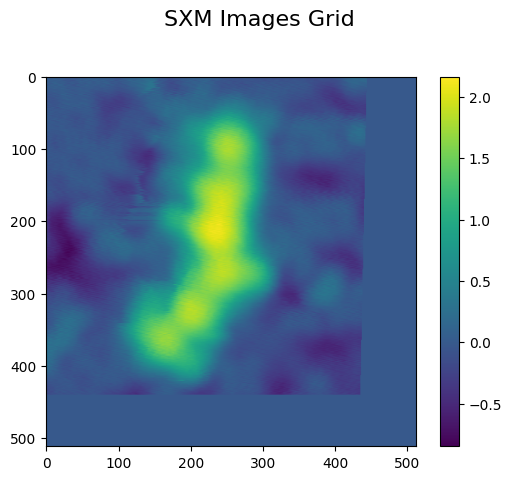

In [18]:
#Check name of your files, you can choose to visualize one file now
name='240314_Cu1000390'
plt.imshow(sxm_data[name]['img'], cmap='viridis')
plt.suptitle('SXM Images Grid', fontsize=16, y=1.02)
plt.colorbar()
plt.show()

In [27]:
# Extract features to DataFrame (without pixel values)
feature_frame = extract_features_to_dataframe(sxm_data, target_size=(128, 128), include_image_pixels=False)



DataFrame created with shape: (3, 22)
Features: ['bias', 'acq_time', 'max_intensity', 'min_intensity', 'intensity_range', 'mean_intensity', 'intensity_skewness', 'intensity_kurtosis', 'entropy', 'edge_density', 'num_contours', 'contrast', 'homogeneity', 'laplacian_variance', 'gradient_magnitude', 'freq_energy_high', 'freq_energy_low', 'freq_ratio_high_low', 'image_height', 'image_width', 'image_aspect_ratio', 'image_area']


In [28]:
feature_frame

,bias,acq_time,max_intensity,min_intensity,intensity_range,mean_intensity,intensity_skewness,intensity_kurtosis,entropy,edge_density,...,homogeneity,laplacian_variance,gradient_magnitude,freq_energy_high,freq_energy_low,freq_ratio_high_low,image_height,image_width,image_aspect_ratio,image_area
sample_name,,,,,,,,,,,,,,,,,,,,,
240314_Cu1000390,-0.1,185.9,2.16428,-0.845945,3.010226,0.174212,1.767348,2.433311,6.002782,0.001831,...,0.999062,0.010821,0.151791,1.907782e+06,1.690051e+06,1.128832,512,512,1.0,262144
240314_Cu1000391,-0.1,185.9,2.16428,-0.845945,3.010226,0.174212,1.767348,2.433311,6.002782,0.001831,...,0.999062,0.010821,0.151791,1.907782e+06,1.690051e+06,1.128832,512,512,1.0,262144
240314_Cu1000392,-0.1,185.9,2.16428,-0.845945,3.010226,0.174212,1.767348,2.433311,6.002782,0.001831,...,0.999062,0.010821,0.151791,1.907782e+06,1.690051e+06,1.128832,512,512,1.0,262144


In [29]:
#We convert to dictionary
feature_dict = feature_frame.to_dict('index')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

def cluster_with_gmm(df, exclude_features=None, variance_threshold=0.01, 
                     max_clusters=None, use_pca=True, n_pca_components=None):
    """
    Perform Gaussian Mixture Model clustering on DataFrame features
    
    Parameters:
    -----------
    df : pd.DataFrame
        Feature DataFrame with samples as rows
    exclude_features : list
        List of feature names to exclude from clustering
    variance_threshold : float
        Minimum variance threshold for feature selection
    max_clusters : int
        Maximum number of clusters to test (default: min(10, n_samples//2))
    use_pca : bool
        Whether to apply PCA before clustering
    n_pca_components : int
        Number of PCA components (default: min(n_samples-1, n_features))
    
    Returns:
    --------
    dict containing clustering results and analysis
    """
    
    print("=== Gaussian Mixture Model Clustering ===")
    print(f"Original DataFrame shape: {df.shape}")
    
    # 1. Feature Selection and Preprocessing
    # Remove specified features
    if exclude_features is None:
        exclude_features = []
    
    # Automatically exclude constant or near-constant features
    constant_features = []
    for col in df.columns:
        if col not in exclude_features:
            if df[col].nunique() <= 1 or df[col].std() < 1e-6:
                constant_features.append(col)
    
    if constant_features:
        print(f"Excluding constant features: {constant_features}")
        exclude_features.extend(constant_features)
    
    # Select features for clustering
    feature_cols = [col for col in df.columns if col not in exclude_features]
    X = df[feature_cols].copy()
    
    print(f"Using {len(feature_cols)} features: {feature_cols[:5]}..." if len(feature_cols) > 5 else f"Using features: {feature_cols}")
    
    # Handle missing values
    if X.isnull().any().any():
        print("Warning: Found missing values, filling with median")
        X = X.fillna(X.median())
    
    # 2. Variance-based feature selection
    if variance_threshold > 0:
        selector = VarianceThreshold(threshold=variance_threshold)
        X_selected = selector.fit_transform(X)
        selected_features = np.array(feature_cols)[selector.get_support()]
        print(f"After variance filtering ({variance_threshold}): {X_selected.shape[1]} features")
        X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    
    # 3. Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    # 4. PCA (optional)
    if use_pca and X_scaled.shape[1] > 3:
        if n_pca_components is None:
            n_pca_components = min(X_scaled.shape[0] - 1, X_scaled.shape[1], 15)
        
        pca = PCA(n_components=n_pca_components, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        
        print(f"PCA: {X_scaled.shape[1]} → {X_pca.shape[1]} components")
        print(f"Explained variance: {pca.explained_variance_ratio_[:5]}")
        print(f"Cumulative variance: {np.cumsum(pca.explained_variance_ratio_)[:5]}")
        
        # Use PCA features for clustering
        clustering_features = X_pca
        feature_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    else:
        pca = None
        clustering_features = X_scaled
        feature_names = X.columns.tolist()
    
    # 5. Determine cluster range
    n_samples = clustering_features.shape[0]
    if max_clusters is None:
        max_clusters = min(8, n_samples - 1)  # Conservative upper limit
    
    cluster_range = range(2, max_clusters + 1)
    print(f"Testing {min(cluster_range)} to {max(cluster_range)} clusters")
    
    # 6. Model Selection with AIC/BIC
    models = []
    aics = []
    bics = []
    silhouette_scores = []
    
    for n_clusters in cluster_range:
        try:
            gmm = GaussianMixture(n_components=n_clusters, random_state=42, 
                                covariance_type='full', max_iter=100)
            gmm.fit(clustering_features)
            
            models.append(gmm)
            aics.append(gmm.aic(clustering_features))
            bics.append(gmm.bic(clustering_features))
            
            # Calculate silhouette score
            labels = gmm.predict(clustering_features)
            if len(np.unique(labels)) > 1:
                sil_score = silhouette_score(clustering_features, labels)
                silhouette_scores.append(sil_score)
            else:
                silhouette_scores.append(-1)
                
        except Exception as e:
            print(f"Failed to fit {n_clusters} clusters: {e}")
            models.append(None)
            aics.append(np.inf)
            bics.append(np.inf)
            silhouette_scores.append(-1)
    
    # Find optimal number of clusters
    optimal_n_aic = cluster_range[np.argmin(aics)]
    optimal_n_bic = cluster_range[np.argmin(bics)]
    optimal_n_sil = cluster_range[np.argmax(silhouette_scores)]
    
    print(f"Optimal clusters - AIC: {optimal_n_aic}, BIC: {optimal_n_bic}, Silhouette: {optimal_n_sil}")
    
    
    # 8. Fit final model (use BIC as it's more conservative)
    optimal_n = optimal_n_bic
    final_gmm = GaussianMixture(n_components=optimal_n, random_state=42, covariance_type='full')
    cluster_labels = final_gmm.fit_predict(clustering_features)
    cluster_probs = final_gmm.predict_proba(clustering_features)
    
    # 9. Results summary
    print(f"\n=== Final Clustering Results ===")
    print(f"Number of clusters: {optimal_n}")
    print(f"Cluster assignments: {cluster_labels}")
    print(f"Cluster sizes: {np.bincount(cluster_labels)}")
    
    if len(np.unique(cluster_labels)) > 1:
        final_silhouette = silhouette_score(clustering_features, cluster_labels)
        print(f"Final silhouette score: {final_silhouette:.3f}")
    
    # 10. Create results DataFrame
    results_df = df.copy()
    results_df['cluster'] = cluster_labels
    results_df['cluster_probability'] = np.max(cluster_probs, axis=1)
    
    # 11. Visualize clusters
    visualize_clusters(clustering_features, cluster_labels, feature_names, 
                      sample_names=df.index, pca_obj=pca)
    
    # 12. Cluster analysis
    analyze_clusters_df(results_df, X.columns)
    
    # Return comprehensive results
    return {
        'results_df': results_df,
        'cluster_labels': cluster_labels,
        'cluster_probabilities': cluster_probs,
        'gmm_model': final_gmm,
        'pca_model': pca,
        'scaler': scaler,
        'selected_features': X.columns.tolist(),
        'clustering_features': clustering_features,
        'optimal_clusters': optimal_n,
        'model_selection': {
            'cluster_range': list(cluster_range),
            'aics': aics,
            'bics': bics,
            'silhouette_scores': silhouette_scores
        }
    }

def visualize_clusters(features, labels, feature_names, sample_names=None, pca_obj=None):
    """Visualize clustering results"""
    
    n_clusters = len(np.unique(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 2D scatter plot (first 2 features/components)
    scatter = axes[0,0].scatter(features[:, 0], features[:, 1], c=labels, 
                               cmap='tab10', s=100, alpha=0.7)
    axes[0,0].set_xlabel(feature_names[0] if len(feature_names) > 0 else 'Feature 1')
    axes[0,0].set_ylabel(feature_names[1] if len(feature_names) > 1 else 'Feature 2')
    axes[0,0].set_title('Clusters in Feature Space')
    
    # Add sample labels if provided
    if sample_names is not None:
        for i, name in enumerate(sample_names):
            axes[0,0].annotate(name, (features[i, 0], features[i, 1]), 
                              xytext=(3, 3), textcoords='offset points', fontsize=8)
    
    # 3D scatter if we have at least 3 features
    if features.shape[1] >= 3:
        ax_3d = fig.add_subplot(2, 2, 2, projection='3d')
        ax_3d.scatter(features[:, 0], features[:, 1], features[:, 2], 
                     c=labels, cmap='tab10', s=60)
        ax_3d.set_xlabel(feature_names[0] if len(feature_names) > 0 else 'Feature 1')
        ax_3d.set_ylabel(feature_names[1] if len(feature_names) > 1 else 'Feature 2')
        ax_3d.set_zlabel(feature_names[2] if len(feature_names) > 2 else 'Feature 3')
        ax_3d.set_title('3D Cluster View')
    
    # Cluster distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    axes[1,0].bar(unique_labels, counts, color=[colors[i] for i in unique_labels])
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].set_ylabel('Number of Samples')
    axes[1,0].set_title('Cluster Sizes')
    
    # Feature importance (if PCA was used)
    if pca_obj is not None and hasattr(pca_obj, 'components_'):
        # Show PCA component weights for first 2 components
        n_orig_features = min(10, pca_obj.components_.shape[1])  # Show top 10 original features
        feature_importance = np.abs(pca_obj.components_[:2, :n_orig_features])
        
        im = axes[1,1].imshow(feature_importance, cmap='viridis', aspect='auto')
        axes[1,1].set_xlabel('Original Features')
        axes[1,1].set_ylabel('PC Components')
        axes[1,1].set_title('PCA Feature Weights')
        plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

def analyze_clusters_df(results_df, feature_columns):
    """Analyze cluster characteristics"""
    
    print(f"\n=== Cluster Analysis ===")
    
    # Group by cluster and calculate statistics
    cluster_stats = results_df.groupby('cluster')[feature_columns].agg(['mean', 'std'])
    
    print("Cluster means:")
    print(cluster_stats.xs('mean', axis=1, level=1).round(3))
    
    # Show which samples are in each cluster
    print(f"\nSample assignments:")
    for cluster_id in sorted(results_df['cluster'].unique()):
        samples = results_df[results_df['cluster'] == cluster_id].index.tolist()
        probs = results_df[results_df['cluster'] == cluster_id]['cluster_probability'].values
        print(f"Cluster {cluster_id}: {samples}")
        print(f"  Probabilities: {[f'{p:.3f}' for p in probs]}")


=== Gaussian Mixture Model Clustering ===
Original DataFrame shape: (39, 27)
Using 27 features: ['bias', 'entropy', 'acq_time', 'max_intensity', 'min_intensity']...
After variance filtering (0.01): 24 features
PCA: 24 → 15 components
Explained variance: [0.54427954 0.14554202 0.09955135 0.05943297 0.0462895 ]
Cumulative variance: [0.54427954 0.68982155 0.78937291 0.84880588 0.89509538]
Testing 2 to 8 clusters
Optimal clusters - AIC: 8, BIC: 5, Silhouette: 2

=== Final Clustering Results ===
Number of clusters: 5
Cluster assignments: [0 3 2 3 3 3 0 0 0 3 1 2 3 0 0 0 3 1 4 3 1 3 4 0 1 0 1 3 3 3 3 0 1 2 0 2 3
 3 4]
Cluster sizes: [11  6  4 15  3]
Final silhouette score: 0.294


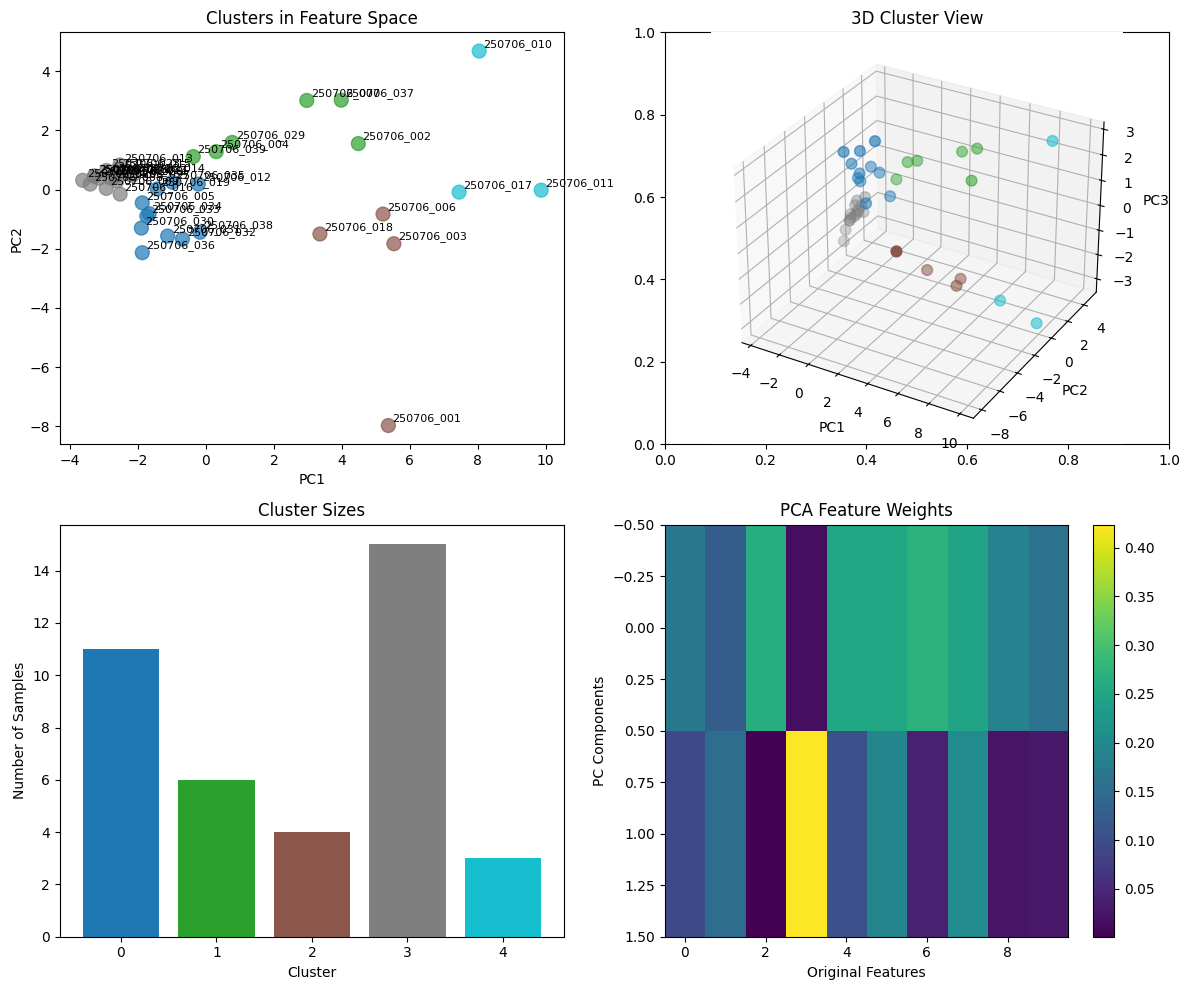


=== Cluster Analysis ===
Cluster means:
         entropy  acq_time  max_intensity  min_intensity  intensity_range  \
cluster                                                                     
0          5.966    71.436          3.758         -1.795            5.553   
1          5.864   116.883         12.185          0.000           12.185   
2          6.128    95.150         16.777         -2.554           19.332   
3          4.815    76.820          2.881         -0.350            3.231   
4          6.068   100.633         21.731          0.000           21.731   

         mean_intensity  std_intensity  median_intensity  intensity_skewness  \
cluster                                                                        
0                 0.298          0.804             0.190               0.606   
1                 3.338          2.407             3.899               0.130   
2                 3.051          3.310             3.069               0.363   
3                 0

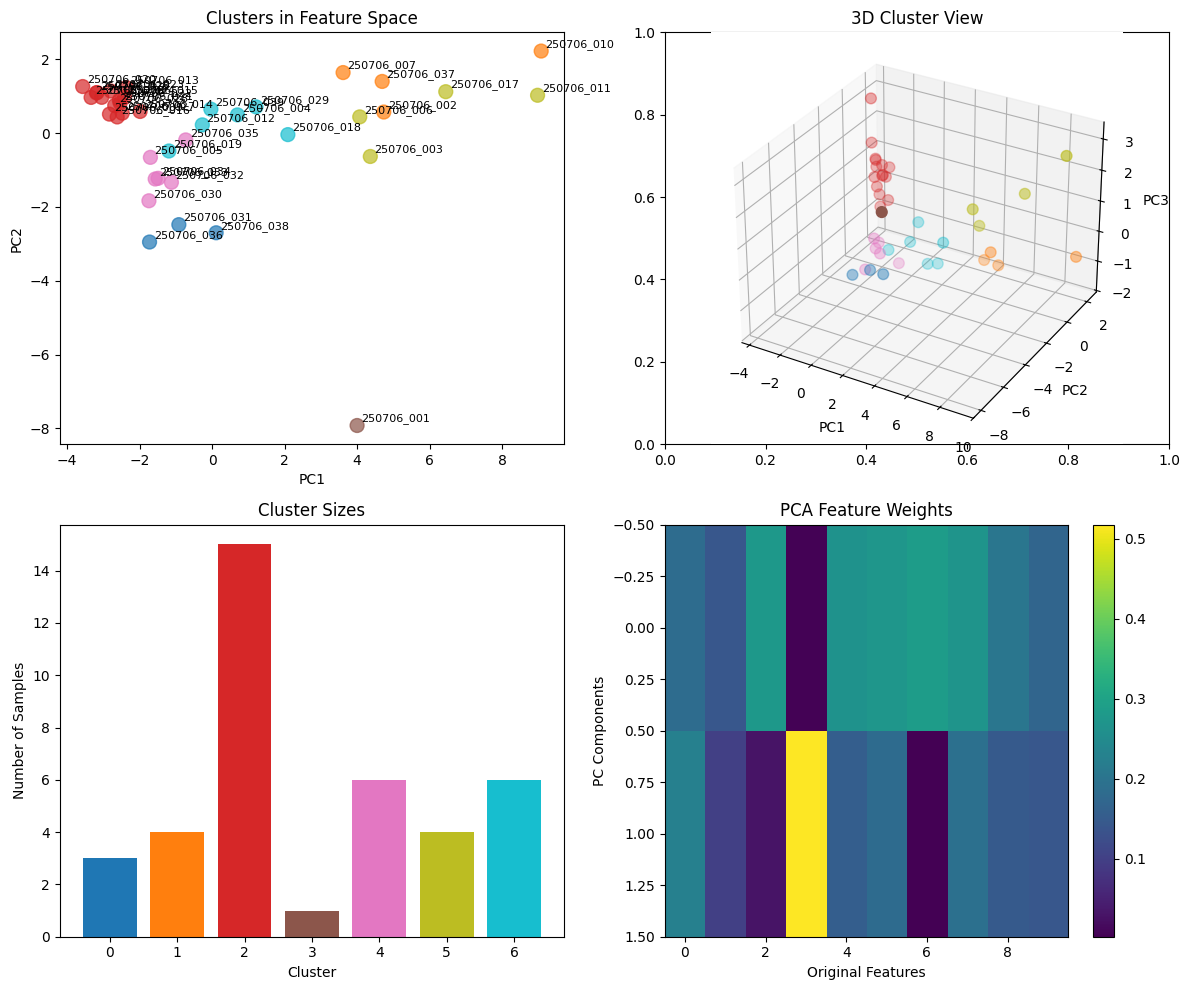


=== Cluster Analysis ===
Cluster means:
         entropy  acq_time  max_intensity  min_intensity  intensity_range  \
cluster                                                                     
0          6.000    87.533          4.247         -2.799            7.046   
1          5.986   122.800         17.080          0.000           17.080   
2          4.815    76.820          2.881         -0.350            3.231   
3          6.059    92.000         21.024        -10.191           31.216   
4          6.024    55.400          2.886         -1.699            4.585   
5          6.026    98.375         19.697         -0.007           19.704   
6          5.879    99.650          8.094         -0.192            8.286   

         mean_intensity  std_intensity  median_intensity  intensity_skewness  \
cluster                                                                        
0                 0.119          0.943             0.000               0.499   
1                 5.464  

In [ ]:
# Basic usage
results = cluster_with_gmm(df)

# Advanced usage with custom parameters
results = cluster_with_gmm(
    df, 
    exclude_features=['image_height', 'image_width', 'image_area'],  # Exclude size features
    variance_threshold=0.01,  # Remove low-variance features
    max_clusters=10,  # Test up to 6 clusters
    use_pca=True,  # Apply PCA
    n_pca_components=8  # Use 8 PCA components
)

# Explore results
print("Cluster assignments:")
print(results['results_df'][['cluster', 'cluster_probability']])

# Get clustered samples
clustered_df = results['results_df']
cluster_0_samples = clustered_df[clustered_df['cluster'] == 0].index.tolist()
print(f"Cluster 0 contains: {cluster_0_samples}")

# Feature importance analysis
if results['pca_model'] is not None:
    pca = results['pca_model']
    print("Top features contributing to PC1:")
    feature_contributions = pd.DataFrame({
        'feature': results['selected_features'],
        'pc1_weight': np.abs(pca.components_[0])
    }).sort_values('pc1_weight', ascending=False)
    print(feature_contributions.head())

In [ ]:
clusters= results['cluster_labels'].tolist() 

In [ ]:
# # 2. Process image features with PCA
# scaler_img = StandardScaler()
# image_features_scaled = scaler_img.fit_transform(image_features)

# pca = PCA(n_components=int(combined_features.shape[0]-1))
# image_features_pca = pca.fit_transform(image_features_scaled)

# # 3. Scale additional features (bias, entropy, acq_time)
# scaler_add = StandardScaler()
# additional_features_scaled = scaler_add.fit_transform(additional_features)

# # 4. Combine all features
# combined_features = np.hstack([
#     image_features_pca,
#     additional_features_scaled
# ])

# print(f"Combined feature shape: {combined_features.shape}")
# print(f"Image PCA explains {pca.explained_variance_ratio_.sum():.3f} of variance")

In [ ]:
# # # kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
# # # clusters = kmeans.fit_predict(combined_features)

# from sklearn.mixture import GaussianMixture
# from sklearn.model_selection import GridSearchCV

# # Automatically find best number of components
# n_components_range = range(3, int(combined_features.shape[0]-1))
# models = [GaussianMixture(n_components=n, random_state=42) 
#           for n in n_components_range]

# # Use AIC/BIC for model selection
# aics = [model.fit(combined_features).aic(combined_features) for model in models]
# optimal_n = n_components_range[np.argmin(aics)]

# # Fit final model
# gmm = GaussianMixture(n_components=optimal_n, random_state=42)
# clusters = gmm.fit_predict(combined_features)

In [ ]:
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 7
Estimated number of noise points: 0


In [ ]:
# Create dictionary with clusters as keys and lists of names as values
cluster_dict = {}
for name, cluster in zip(list(results['results_df'].index), results['cluster_labels']):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(name)

print(cluster_dict)


{np.int64(4): ['250706_005', '250706_035', '250706_034', '250706_032', '250706_033', '250706_030'], np.int64(2): ['250706_024', '250706_013', '250706_023', '250706_015', '250706_020', '250706_014', '250706_021', '250706_009', '250706_027', '250706_008', '250706_016', '250706_022', '250706_025', '250706_026', '250706_028'], np.int64(6): ['250706_018', '250706_012', '250706_019', '250706_039', '250706_004', '250706_029'], np.int64(1): ['250706_007', '250706_010', '250706_002', '250706_037'], np.int64(5): ['250706_006', '250706_017', '250706_003', '250706_011'], np.int64(0): ['250706_038', '250706_031', '250706_036'], np.int64(3): ['250706_001']}


In [ ]:
for i in range(n_clusters): 
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(sub_new, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    save_plots_dicts(
        sxm_data,
        cluster_dict, 
        clus=i,
        save_path=sub_new,
        image_key='img', 
        name_file='classified_unprocessed', # Your base path where cluster folders are
        n_cols=10,save_dict=True
    )

Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0
Saved cluster 0 dictionary to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0\classified_unprocessed_0.pkl
Saved cluster 0 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0\classified_unprocessed_0.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1
Saved cluster 1 dictionary to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1\classified_unprocessed_1.pkl
Saved cluster 1 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1\classified_unprocessed_1.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2
Saved cluster 2 dictionary to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2\classified_unprocessed_2.pkl
Saved cluster 2 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2\classified_unprocessed_2.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LH

In [ ]:
# Define feature keys
feature_keys = [
    'bias', 'entropy', 'acq_time',
    'intensity_range', 'mean_intensity', 'std_intensity',
    'edge_density', 'num_contours', 'contrast', 'homogeneity',
    'laplacian_variance', 'gradient_magnitude',
    'freq_energy_high', 'freq_energy_low'
]

# Extract to array
names = list(more_features.keys())
additional_features = np.array([[more_features[name][key] for key in feature_keys] for name in names])

In [ ]:
# Generate filter configurations for all clusters
cluster_configs, df, cluster_stats = run_cluster_config_analysis(
    additional_features, names, clusters
)

 CLUSTER FILTER CONFIGURATIONS

 CLUSTER 0 (3 images)
 Characteristics:
   Edge: 0.010, Contrast: 15.422
   Sharpness: 0.1, Objects: 3.3

⚙️  Filter Configuration:
cluster_0_filters = {
    'fft_filter': {'type': 'gaussian', 'sigma': 14.0, 'decay_rate': 0.06},
    'unsharp_mask': {'radius': 4.0, 'amount': 15.0},
    'invert': False,
    'cosine': False,
    'blur_sigma': 1.0
}

💡 Reasoning:
   FFT Gaussian: Noise reduction/smoothing

📸 Sample Images: 250706_038, 250706_031, 250706_036

 CLUSTER 1 (4 images)
 Characteristics:
   Edge: 0.011, Contrast: 0.695
   Sharpness: 1.5, Objects: 1.0

⚙️  Filter Configuration:
cluster_1_filters = {
    'fft_filter': {'type': 'gaussian', 'sigma': 20.0, 'decay_rate': 0.06},
    'unsharp_mask': {'radius': 4.0, 'amount': 15.0},
    'invert': False,
    'cosine': True,
    'blur_sigma': 1.0
}

💡 Reasoning:
   FFT Gaussian: Noise reduction/smoothing
   Cosine: Low contrast enhancement

📸 Sample Images: 250706_007, 250706_010, 250706_002

 CLUSTER 2 (15 i

In [ ]:
# Initialize storage for all processed clusters
cluster_processed = {}

# Process each cluster
for cluster_id in range(n_clusters): 
    
    # Initialize cluster storage
    
    cluster_config = cluster_configs[f'cluster_{cluster_id}_filters']
    
    # Get images in this cluster
    cluster_images = cluster_dict[cluster_id]
   
    # Process each image in the cluster
    for name in cluster_images:
        
        # Get image data
        image = sxm_data[name]['img']
        zmask = sxm_data[name]['Zmask']
        
        try:
            # Apply SXM processing function with cluster-specific config
            result = process_sxm_image(image, zmask, cluster_config)
            processed_image = result['processed_image']
            
            # Calculate entropy for processed image
            try:
                image_entropy = calculate_entropy(processed_image)
            except:
                image_entropy = sxm_data[name].get('entropy', 0)
            
            # Store processed data
            cluster_processed[name] = {
                'original_img': image,
                'processed_img': processed_image,
                'Zmask': zmask,
                'Pixelsize': sxm_data[name]['Pixelsize'],
                'entropy': image_entropy,
                'bias': sxm_data[name]['bias'],
                'acq_time': sxm_data[name]['acq_time'],
                'header': sxm_data[name]['header'],
                'filters_applied': cluster_config.copy(),
                'processing_result': result  # Store full result if needed
            }
            
            print(f"  ✅ Processing successful")
            
        except Exception as e:
            print(f"  ❌ Error processing {name}: {e}")
            
            # Store original data if processing fails
            cluster_processed[name] = {
                'original_img': image,
                'processed_img': image,  # Use original as fallback
                'Zmask': zmask,
                'Pixelsize': sxm_data[name]['Pixelsize'],
                'entropy': sxm_data[name].get('entropy', 0),
                'bias': sxm_data[name]['bias'],
                'acq_time': sxm_data[name]['acq_time'],
                'header': sxm_data[name]['header'],
                'filters_applied': {},
                'processing_result': None,
                'error': str(e)
            }
    
    # Store cluster results
    all_processed_clusters=cluster_processed

  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processing successful
  ✅ Processi

In [ ]:
for i in range(n_clusters): 
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(sub_new, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    save_plots_dicts(
        all_processed_clusters,
        cluster_dict, 
        clus=i,
        save_path=sub_new,
        image_key='processed_img', 
        name_file='classified_processed', # Your base path where cluster folders are
        n_cols=10
    )

Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0
Saved cluster 0 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0\classified_processed_0.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1
Saved cluster 1 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1\classified_processed_1.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2
Saved cluster 2 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2\classified_processed_2.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3
Saved cluster 3 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3\classified_processed_3.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4
Saved cluster 4 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4\classified_processed_4.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LH

In [ ]:
# Load your image
otsus={}
for cluster_id in range(n_clusters): 
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        img = all_processed_clusters[name]['processed_img']
        otsus[name]=results = remove_background_outside_edges(img,gauss=False, sensitivity='low')

Low sensitivity: Using 66.5 instead of Otsu 95.0
Low sensitivity: Using 63.7 instead of Otsu 91.0
Low sensitivity: Using 46.9 instead of Otsu 67.0
Low sensitivity: Using 165.9 instead of Otsu 237.0
Low sensitivity: Using 166.6 instead of Otsu 238.0
Low sensitivity: Using 144.2 instead of Otsu 206.0
Low sensitivity: Using 160.3 instead of Otsu 229.0
Low sensitivity: Using 79.8 instead of Otsu 114.0
Low sensitivity: Using 74.2 instead of Otsu 106.0
Low sensitivity: Using 79.8 instead of Otsu 114.0
Low sensitivity: Using 70.0 instead of Otsu 100.0
Low sensitivity: Using 65.1 instead of Otsu 93.0
Low sensitivity: Using 63.0 instead of Otsu 90.0
Low sensitivity: Using 79.8 instead of Otsu 114.0
Low sensitivity: Using 76.3 instead of Otsu 109.0
Low sensitivity: Using 74.9 instead of Otsu 107.0
Low sensitivity: Using 79.1 instead of Otsu 113.0
Low sensitivity: Using 67.9 instead of Otsu 97.0
Low sensitivity: Using 79.8 instead of Otsu 114.0
Low sensitivity: Using 78.4 instead of Otsu 112.0
Lo

In [ ]:
deep_update(all_processed_clusters, otsus)

In [ ]:
for i in range(n_clusters): 
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(sub_new, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    save_plots_dicts(
        all_processed_clusters,
        cluster_dict, 
        clus=i,
        save_path=sub_new,
        image_key='result_black_bg', 
        name_file='otsu_background', # Your base path where cluster folders are
        n_cols=10
    )

Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0
Saved cluster 0 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0\otsu_background_0.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1
Saved cluster 1 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1\otsu_background_1.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2
Saved cluster 2 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2\otsu_background_2.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3
Saved cluster 3 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3\otsu_background_3.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4
Saved cluster 4 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4\otsu_background_4.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_5
Saved c

In [ ]:
# Process all images with distance transform

for cluster_id in range(n_clusters): 
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        img = all_processed_clusters[name]['original_img']
        mask = all_processed_clusters[name]['mask']
        
        # Get distance transform (no plot for batch processing)
        distance_array = get_distance_transform(img, mask, name)
        
        # Store the result
        all_processed_clusters[name].update({
            'distance_transform': distance_array,
            'max_distance': distance_array.max(),
            'mean_distance': distance_array[distance_array > 0].mean() if np.sum(distance_array > 0) > 0 else 0,
            'image_shape': img.shape,
            'non_zero_pixels': np.sum(distance_array > 0)
        })


🔍 Distance Transform for: 250706_038
   Shape: (512, 512)
   Max distance: 79.50 pixels
   Non-zero pixels: 61465
🔍 Distance Transform for: 250706_031
   Shape: (512, 512)
   Max distance: 24.58 pixels
   Non-zero pixels: 18012
🔍 Distance Transform for: 250706_036
   Shape: (512, 512)
   Max distance: 71.40 pixels
   Non-zero pixels: 37670
🔍 Distance Transform for: 250706_007
   Shape: (512, 512)
   Max distance: 340282346638528859811704183484516925440.00 pixels
   Non-zero pixels: 262144
🔍 Distance Transform for: 250706_010
   Shape: (512, 512)
   Max distance: 340282346638528859811704183484516925440.00 pixels
   Non-zero pixels: 262144
🔍 Distance Transform for: 250706_002
   Shape: (401, 512)
   Max distance: 340282346638528859811704183484516925440.00 pixels
   Non-zero pixels: 205312
🔍 Distance Transform for: 250706_037
   Shape: (512, 512)
   Max distance: 340282346638528859811704183484516925440.00 pixels
   Non-zero pixels: 262144
🔍 Distance Transform for: 250706_024
   Shape: (51

In [ ]:
for i in range(n_clusters): 
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(sub_new, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    save_plots_dicts(
        all_processed_clusters,
        cluster_dict, 
        clus=i,
        save_path=sub_new,
        image_key='distance_transform', 
        name_file='distance_transform', # Your base path where cluster folders are
        n_cols=10
    )

Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0
Saved cluster 0 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0\distance_transform_0.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1
Saved cluster 1 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1\distance_transform_1.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2
Saved cluster 2 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2\distance_transform_2.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3
Saved cluster 3 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3\distance_transform_3.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4
Saved cluster 4 plot to: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4\distance_transform_4.png
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cl

In [ ]:
for cluster_id in range(n_clusters): 
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
        # Get the original image
        img = all_processed_clusters[name]['original_img']
    
        # Get pixel size information
        pixelsize = all_processed_clusters[name]['Pixelsize']  # [x_nm_per_pixel, y_nm_per_pixel]

        distance_transform = all_processed_clusters[name]['distance_transform']

        # Extract backbone using ridge method
        backbone_ridge = extract_backbone_from_distance_transform(img, distance_transform, name, method='ridge')
        
        # Get detailed measurements WITH pixel size
        measurements = analyze_backbone_measurements(backbone_ridge['backbone_points'], name, pixelsize)

        all_processed_clusters[name]['backbone_ridge'] = backbone_ridge
        all_processed_clusters[name]['measurements'] = measurements

🧬 Extracting backbone from distance transform: 250706_038
   Ridge method: 3101 backbone points
   Backbone length: 10142.9 pixels
   Distance transform max: 79.5
🧬 Extracting backbone from distance transform: 250706_031
   Ridge method: 1595 backbone points
   Backbone length: 28976.7 pixels
   Distance transform max: 24.6
🧬 Extracting backbone from distance transform: 250706_036
   Ridge method: 5988 backbone points
   Backbone length: 15546.1 pixels
   Distance transform max: 71.4
🧬 Extracting backbone from distance transform: 250706_007
   Ridge method: 262144 backbone points
   Backbone length: 522753.5 pixels
   Distance transform max: 340282346638528859811704183484516925440.0
🧬 Extracting backbone from distance transform: 250706_010
   Ridge method: 262144 backbone points
   Backbone length: 522753.5 pixels
   Distance transform max: 340282346638528859811704183484516925440.0
🧬 Extracting backbone from distance transform: 250706_002
   Ridge method: 205312 backbone points
   Back

In [ ]:
def plot_backbone_comprehensive_grid(all_processed_clusters,
                                    cluster_dict,
                                    clus, save_path, name_file='which', n_cols=10, show_plot=False):
    """Plot comprehensive backbone visualization grid for a cluster"""
   
    if not all_processed_clusters or clus not in cluster_dict:
        print(f"No data or cluster {clus} not found")
        return None
   
    cluster_folder = os.path.join(save_path, f'cluster_{clus}')
    os.makedirs(cluster_folder, exist_ok=True)
    
    # Calculate grid dimensions
    n_files = len(cluster_dict[clus])
    n_rows = int(np.ceil(n_files / n_cols))
   
    # Create the figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
   
    # Handle axes dimension edge cases
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_files == 1:
        axes = np.array([[axes]])
   
    # Plot each image in the cluster
    for idx, name in enumerate(cluster_dict[clus]):
        row = idx // n_cols
        col = idx % n_cols
       
        backbone_result = all_processed_clusters[name]['backbone_ridge']
        measurements = all_processed_clusters[name]['measurements']
        
        # Plot the image
        backbone_rgb = cv2.cvtColor(backbone_result['visualization'], cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(backbone_rgb)
        
        # Title with key measurements in NANOMETERS
        title = f'{name}\n'
        title += f'Length: {measurements["backbone_length_nm"]:.1f} nm\n'
        title += f'E2E: {measurements["end_to_end_distance_nm"]:.1f} nm\n'
        title += f'Ratio: {measurements["contour_ratio"]:.2f}'
       
        axes[row, col].set_title(title, fontsize=8)
        axes[row, col].axis('off')
   
    # Hide empty subplots
    for idx in range(n_files, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
   
    plt.suptitle(f'All Backbone Analyses - Cluster {clus} ({n_files} images)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
   
    # Save plot
    plot_file = os.path.join(cluster_folder, f'{name_file}_{clus}.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    # Only show if requested
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
   
    return plot_file

In [ ]:
for i in range(n_clusters): 
    cluster_folder = f'cluster_{i}'
    cluster_path = os.path.join(sub_new, cluster_folder)
    os.makedirs(cluster_path, exist_ok=True)
    print(f'Created: {cluster_path}')

    plot_backbone_comprehensive_grid(
        all_processed_clusters,
        cluster_dict, 
        clus=i,
        save_path=sub_new,
        name_file='backbones'
    )

Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_0
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_1
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_2
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_3
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_4
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_5
Created: Z:\Results\Batch_processing\(NKN)2\20250706_LHe_Ag111\cluster_6


In [ ]:
def calculate_circle_radii_in_pixels(pixelsize):
    """
    Convert physical radii to pixel units
    
    Parameters:
    -----------
    pixelsize : array-like
        Pixel size in nm/pixel [x, y]
    
    Returns:
    --------
    min_radius_px, max_radius_px : int
        Minimum and maximum radii in pixels
    """
    # Physical dimensions in nm
    min_radius_physical = 0.3  # 1.2 Angstroms = 0.12 nm
    max_radius_physical = 0.5   # 2.0 Angstroms = 0.2 nm
    
    # Use average pixel size (they're nearly identical anyway)
    avg_pixelsize = np.mean(pixelsize)  # nm/pixel
    
    # Convert to pixels
    min_radius_px = int(np.round(min_radius_physical / avg_pixelsize))
    max_radius_px = int(np.round(max_radius_physical / avg_pixelsize))
    
    # print(f"Physical radii: {min_radius_physical:.2f} - {max_radius_physical:.2f} nm")
    # print(f"Pixel size: {avg_pixelsize:.6f} nm/pixel")
    # print(f"Radii in pixels: {min_radius_px} - {max_radius_px} pixels")
    
    return min_radius_px, max_radius_px

In [ ]:
radius={}
for cluster_id in range(n_clusters): 
    cluster_images = cluster_dict[cluster_id]
    for name in cluster_images:
         radius[name]= calculate_circle_radii_in_pixels(all_processed_clusters[name]['Pixelsize'])

In [ ]:
with open(os.path.join(os.path.join(new_path,specific_path),'processed_data.pkl'), 'wb') as f:
    pickle.dump(all_processed_clusters, f)
with open(os.path.join(os.path.join(new_path,specific_path),'cluster_dict.pkl'), 'wb') as f:
    pickle.dump(cluster_dict, f)

In [ ]:
# for cluster_id in range(n_clusters): 
#     cluster_images = cluster_dict[cluster_id]
#     for name in cluster_images:
#         circles = cv.HoughCircles(all_processed_clusters[name]['mask'], cv.HOUGH_GRADIENT, 1, 2,
#                                 param1=100,    
#                                 param2=5,    # Lower since we pre-filtered
#                                 minRadius=radius[name][0],  # Start smaller to see what's detected
#                                 maxRadius=radius[name][1])
        
#         if circles is not None:
#             circles = np.uint16(np.around(circles))
#             print(f"Found {len(circles[0])} maximum height regions")
        
#             valid_circles = []
#             for i in circles[0,:]:
#                 # Check bounds first
#                 if 0 <= i[1] < img.shape[0] and 0 <= i[0] < img.shape[1]:
#                     center_intensity = img[i[1], i[0]]
                    
#                     # Only process circles with intensity > 0
#                     if center_intensity > 0:
#                         cv.circle(img, (i[0], i[1]), i[2], (255, 192, 203), 2)  # Pink circle outline
#                         cv.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)
#                         # print(f"Circle at ({i[0]}, {i[1]}) with radius {i[2]}, intensity {center_intensity}")
#                         valid_circles.append(i)
#                     else:
#                         """#print(f"Skipping circle at ({i[0]}, {i[1]}) - intensity 0")"""
#                         continue
#         # Display with matplotlib instead of OpenCV window
#         plt.figure(figsize=(10, 10))
#         plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
#         plt.title('Maximum Height Circles')
#         plt.axis('off')  # Remove axis ticks and labels
#         plt.show()